In [1]:
import jax
from jax import jit
from jax import lax
from jax import vmap
import jax.numpy as jnp

from functools import partial

jax.config.update('jax_enable_x64', True)

In [2]:
import math
import numpy as np
import plotly.express as px
import IPython
import matplotlib.pyplot as plt 
import ipywidgets as widgets

%config InlineBackend.figure_formats = ['svg']

In [3]:
from jax_control_algorithms.trajectory_optimization import Solver, Functions, SolverSettings, ProblemDefinition, constraint_geq, constraint_leq, unpack_res, generate_penalty_parameter_trace
from jax_control_algorithms.ui import manual_investigate, solve_and_plot, plot_iterations
from jax_control_algorithms.common import rk4

def make_time_vectors(X_opt, U_opt):
    # make time vectors
    t_X = jnp.linspace(0, X_opt.shape[0]-1, X_opt.shape[0])
    t_U = jnp.linspace(0, U_opt.shape[0]-1, U_opt.shape[0])
    
    return t_X, t_U

In [4]:
test_results = []

# Define the optimization problem: single-integrator dynamics

In [5]:
def problem_def_integrator(n_steps, dt):
        
    def model(x, u, k, parameters):
        del k
        x_1,  = x

        a,   = parameters['a'], 
        x_1_dot = jnp.squeeze(u) - a * x_1

        x_dot = jnp.array([
            x_1_dot,
        ])

        # cost
        J = parameters['wu'] * u**2
        
        return x_dot, J

    def f(x, u, k, parameters):
        x_dot, _ = model(x, u, k, parameters)
        return x_dot

    def g(x, u, k, parameters):
        
        x_dot, _ = model(x, u, k, parameters)
        return 

    def cost(X, U, K, parameters):
        J_u = 0.1  * jnp.mean( jnp.diff( U[:,0] / dt )**2 )
        return J_u
    
    def running_cost(x, u, k, parameters):
        
        x_dot, J = model(x, u, k, parameters)
        J_normalized = J * 1.0 / n_steps
        
        return J_normalized
        
    def terminal_constraints(x_final, parameters):
        x_1, = x_final
        
        return jnp.array([
            x_1 - parameters['x_1_final'],           # != 0
        ])
    
    def inequality_constraints(X, U, K, parameters):
        
        U = U[:,0]
        
        # constraints
        c_ineq = jnp.array([
            constraint_geq( U, parameters['u_min'] ),
            constraint_leq( U, parameters['u_max'] ),
            
        ])
        
        return c_ineq

    def initial_guess(x0, parameters):
                
        U_guess = jnp.zeros( (n_steps, 1) )
        X_guess = jnp.vstack((
            jnp.linspace( x0[0], parameters['x_1_final'], n_steps),
        )).T
        
        return { 'X_guess' : X_guess, 'U_guess' : U_guess }
    
    parameters = {
        'a'             : 5.0, 
        'wu'            : 1.00,
        'u_min'         : -2.5,
        'u_max'         : 2.5,
        'x_1_final'     : 1.0,
    }
    
    x0 = jnp.array([ 0.0, ])
    
    #
    f_dscr = rk4(f, dt)

    return ProblemDefinition(
        functions = Functions(
            f                      = f_dscr,
            initial_guess          = initial_guess,
            g                      = g,
            cost                   = cost,
            running_cost           = running_cost,
            terminal_constraints   = terminal_constraints,
            inequality_constraints = inequality_constraints,
        ),
        x0 = x0,
        parameters = parameters,
    )
    
def set_parameters_fn(solver, a, u_min, u_max):
        solver.problem_definition.parameters['a'] = a
        solver.problem_definition.parameters['u_min'] = u_min
        solver.problem_definition.parameters['u_max'] = u_max


In [6]:
def plot_integrator(X_opt, U_opt, system_outputs, parameters):

    # prepare data
    u = U_opt[:,0]
    x_1, =  X_opt[:,0], 

    _ = system_outputs # unpack output variable (return of function g)

    # make time vectors
    t_X, t_U = make_time_vectors(X_opt, U_opt)
    
    # Create a figure and two subplots
    fig, (ax1, ax2, ) = plt.subplots(2, 1, sharex=True, figsize=(4, 6))

    ax1.plot( t_X, x_1, 'k', label='x_1')
    ax1.plot(
        [ t_X[0], t_X[-1] ], 
        jnp.array([parameters['x_1_final'], parameters['x_1_final']]), 'k:',
        label='x_1_final'
    )
    
    ax1.legend()
    ax1.set_ylabel('x_1 []')
    ax1.set_title('integrator state')

    # 
    ax2.plot( t_U, u, 'k', label='u' )    
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([parameters['u_min'], parameters['u_min']]), ':k',
        label='u_min'
    )
    ax2.plot(
        [ t_U[0], t_U[-1] ], 
        jnp.array([parameters['u_max'], parameters['u_max']]), ':k',
        label='u_max'
    )
    
    ax2.legend()
    ax2.set_ylabel('u []')
    ax2.set_title('control variable')

    # Show the plot
    plt.show()

# Solve

compiling optimizer...
👉 solving problem with n_horizon=50, n_states=1 n_inputs=1
🔄 it=0 	 (sub iter=63)	t=0 	eq_error/eq_tol=104193  gain=0.0 lambda=1.7066377344920718 	inside bounds: True
🔄 it=1 	 (sub iter=65)	t=1 	eq_error/eq_tol=73529  gain=1.4170320198395614 lambda=1.733291007425863 	inside bounds: True
🔄 it=2 	 (sub iter=70)	t=2 	eq_error/eq_tol=48382  gain=1.5197643926417277 lambda=1.7541307356723017 	inside bounds: True
🔄 it=3 	 (sub iter=73)	t=3 	eq_error/eq_tol=30035  gain=1.6108713716793888 lambda=1.769139453454021 	inside bounds: True
🔄 it=4 	 (sub iter=74)	t=6 	eq_error/eq_tol=17858  gain=1.6818532490422464 lambda=1.779113355699883 	inside bounds: True
🔄 it=5 	 (sub iter=76)	t=12 	eq_error/eq_tol=10311  gain=1.7319130537763767 lambda=1.7851031309122738 	inside bounds: True
🔄 it=6 	 (sub iter=75)	t=22 	eq_error/eq_tol=5846  gain=1.7637528054797666 lambda=1.7881742025455243 	inside bounds: True
🔄 it=7 	 (sub iter=74)	t=42 	eq_error/eq_tol=3282  gain=1.7812344130577584 lambd

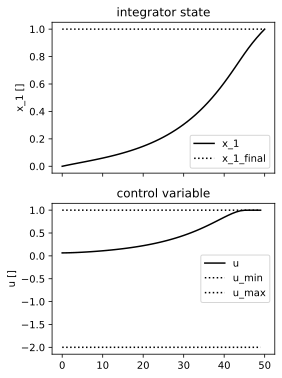

In [7]:
solver = Solver( 
    partial(
        problem_def_integrator, n_steps = 50, dt=0.1,
    ),
    solver_settings=SolverSettings(
        penalty_parameter_trace=generate_penalty_parameter_trace(t_start=0.5, t_final=1000.0, n_steps=13)
    ),
)

set_parameters_fn(solver, a=0.7,  u_min=-2, u_max=1.0)
solver.verbose = True
X_opt, U_opt, system_outputs, res = solver.run()

# plot the results
plot_integrator(X_opt, U_opt, system_outputs, solver.problem_definition.parameters)

## investigate the convergence process

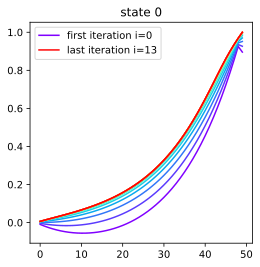

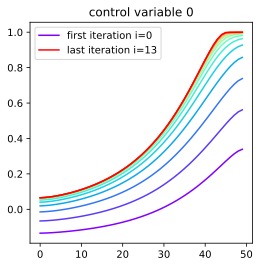

In [8]:
# show the convergence process
fig1, fig2 = plot_iterations(res, (4,4) )

# Manual investigation

In [9]:
sliders = {
        'a'     : widgets.FloatSlider(min=0.0,  max=1.0,  step=0.01,  value=0.7,  description='a'),
        'u_min' : widgets.FloatSlider(min=-2,   max=0,    step=0.01,  value=-2,   description='u_min'),
        'u_max' : widgets.FloatSlider(min=0,    max=2,    step=0.01,  value=1,    description='u_max'),
}

solver = Solver( partial(problem_def_integrator, n_steps = 50, dt=0.1) )

In [10]:
ui, output_box, print_output, plot_output = manual_investigate(solver, sliders, set_parameters_fn, plot_integrator )
display(ui, plot_output, print_output)

GridBox(children=(FloatSlider(value=0.7, description='a', max=1.0, step=0.01), FloatSlider(value=-2.0, descrip…

Output()

Output()

In [11]:
test_results.append( ['single integrator', solver.success ] )

# Verify

In [12]:
def verify_test_results(test_results):
    for r in test_results:
        if not r[1]:
            raise BaseException('Test ' + r[0] + ' failed')
            
verify_test_results(test_results)